<a href="https://colab.research.google.com/github/oleksii-shcherbak/GoIT-num-prog-py-hw/blob/main/hw_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Step 2

In [2]:
import os
import zipfile
import requests
from tqdm import tqdm

def download_esc50():
    """
    Download ESC-50 dataset from GitHub.

    Returns
    -------
    str
        Path to the extracted dataset
    """
    url = "https://github.com/karolpiczak/ESC-50/archive/master.zip"
    dataset_path = "ESC-50-master"

    if not os.path.exists(dataset_path):
        print("Downloading ESC-50 dataset...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open("ESC-50.zip", 'wb') as file:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc='Downloading') as pbar:
                for data in response.iter_content(chunk_size=1024):
                    file.write(data)
                    pbar.update(len(data))

        print("Extracting dataset...")
        with zipfile.ZipFile("ESC-50.zip", 'r') as zip_ref:
            zip_ref.extractall(".")

        print("Dataset ready!")
    else:
        print("Dataset already exists.")

    return dataset_path

# Download dataset
dataset_path = download_esc50()

# Load metadata
metadata_path = os.path.join(dataset_path, 'meta', 'esc50.csv')
metadata = pd.read_csv(metadata_path)

print(f"Dataset loaded successfully!")
print(f"Total samples: {len(metadata)}")
print(f"Unique categories: {metadata['category'].nunique()}")
print(f"\nFirst 5 entries:")
print(metadata.head())

Downloading: 646MB [00:45, 14.3MB/s]


Extracting dataset...
Dataset ready!
Dataset loaded successfully!
Total samples: 2000
Unique categories: 50

First 5 entries:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


### Step 3

In [3]:
# Filter for specific categories
categories = ['dog', 'chirping_birds']
filtered_metadata = metadata[metadata['category'].isin(categories)].copy()

print(f"Filtered dataset statistics:")
print(f"Total samples: {len(filtered_metadata)}")
print(f"\nSamples per category:")
print(filtered_metadata['category'].value_counts())

# Reset index for easier iteration
filtered_metadata.reset_index(drop=True, inplace=True)

# Display sample information
print(f"\nSample files:")
for category in categories:
    samples = filtered_metadata[filtered_metadata['category'] == category].head(3)
    print(f"\n{category.upper()}:")
    for _, row in samples.iterrows():
        print(f"  - {row['filename']}")

Filtered dataset statistics:
Total samples: 80

Samples per category:
category
dog               40
chirping_birds    40
Name: count, dtype: int64

Sample files:

DOG:
  - 1-100032-A-0.wav
  - 1-110389-A-0.wav
  - 1-30226-A-0.wav

CHIRPING_BIRDS:
  - 1-100038-A-14.wav
  - 1-34495-A-14.wav
  - 1-34497-A-14.wav


### Step 4

In [4]:
def generate_spectrogram(audio_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    """
    Generate spectrogram from audio file using FFT.

    Parameters
    ----------
    audio_path : str
        Path to audio file
    sr : int
        Sample rate
    n_fft : int
        FFT window size
    hop_length : int
        Number of samples between successive frames
    n_mels : int
        Number of Mel bands

    Returns
    -------
    np.ndarray
        Spectrogram matrix
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Compute Short-Time Fourier Transform (STFT)
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # Convert to magnitude spectrogram
    S = np.abs(D)

    # Convert to decibel scale
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    return S_db

def generate_mel_spectrogram(audio_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    """
    Generate Mel-spectrogram from audio file.

    Parameters
    ----------
    audio_path : str
        Path to audio file
    sr : int
        Sample rate
    n_fft : int
        FFT window size
    hop_length : int
        Number of samples between successive frames
    n_mels : int
        Number of Mel bands

    Returns
    -------
    np.ndarray
        Mel-spectrogram matrix
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Compute Mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                       hop_length=hop_length, n_mels=n_mels)

    # Convert to decibel scale
    S_db = librosa.power_to_db(S, ref=np.max)

    return S_db

### Step 5

In [5]:
def pooling(spectrogram, pool_size=(2, 2), pool_type='max'):
    """
    Apply pooling to reduce spectrogram dimensions.

    Parameters
    ----------
    spectrogram : np.ndarray
        Input spectrogram
    pool_size : tuple
        Size of pooling window (height, width)
    pool_type : str
        Type of pooling ('max' or 'avg')

    Returns
    -------
    np.ndarray
        Pooled spectrogram
    """
    h_pool, w_pool = pool_size
    h, w = spectrogram.shape

    # Calculate output dimensions
    h_out = h // h_pool
    w_out = w // w_pool

    # Initialize output
    pooled = np.zeros((h_out, w_out))

    # Apply pooling
    for i in range(h_out):
        for j in range(w_out):
            # Extract window
            window = spectrogram[i*h_pool:(i+1)*h_pool,
                                j*w_pool:(j+1)*w_pool]

            # Apply pooling operation
            if pool_type == 'max':
                pooled[i, j] = np.max(window)
            elif pool_type == 'avg':
                pooled[i, j] = np.mean(window)

    return pooled

### Step 6

In [6]:
# Initialize storage for features
spectrograms = []
pooled_spectrograms = []
features = []
labels = []

# Process each audio file
print("Processing audio files...")
audio_dir = os.path.join(dataset_path, 'audio')

for idx, row in tqdm(filtered_metadata.iterrows(), total=len(filtered_metadata)):
    audio_path = os.path.join(audio_dir, row['filename'])

    try:
        # Generate spectrogram
        spec = generate_mel_spectrogram(audio_path)

        # Apply pooling to reduce dimensions
        pooled_spec = pooling(spec, pool_size=(4, 4), pool_type='max')

        # Flatten to create feature vector
        feature_vector = pooled_spec.flatten()

        # Store results
        spectrograms.append(spec)
        pooled_spectrograms.append(pooled_spec)
        features.append(feature_vector)
        labels.append(row['category'])

    except Exception as e:
        print(f"Error processing {row['filename']}: {e}")

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

print(f"\nProcessing complete!")
print(f"Feature matrix shape: {features.shape}")
print(f"Number of features per sample: {features.shape[1]}")

Processing audio files...


100%|██████████| 80/80 [00:19<00:00,  4.08it/s]


Processing complete!
Feature matrix shape: (80, 1728)
Number of features per sample: 1728


### Step 7

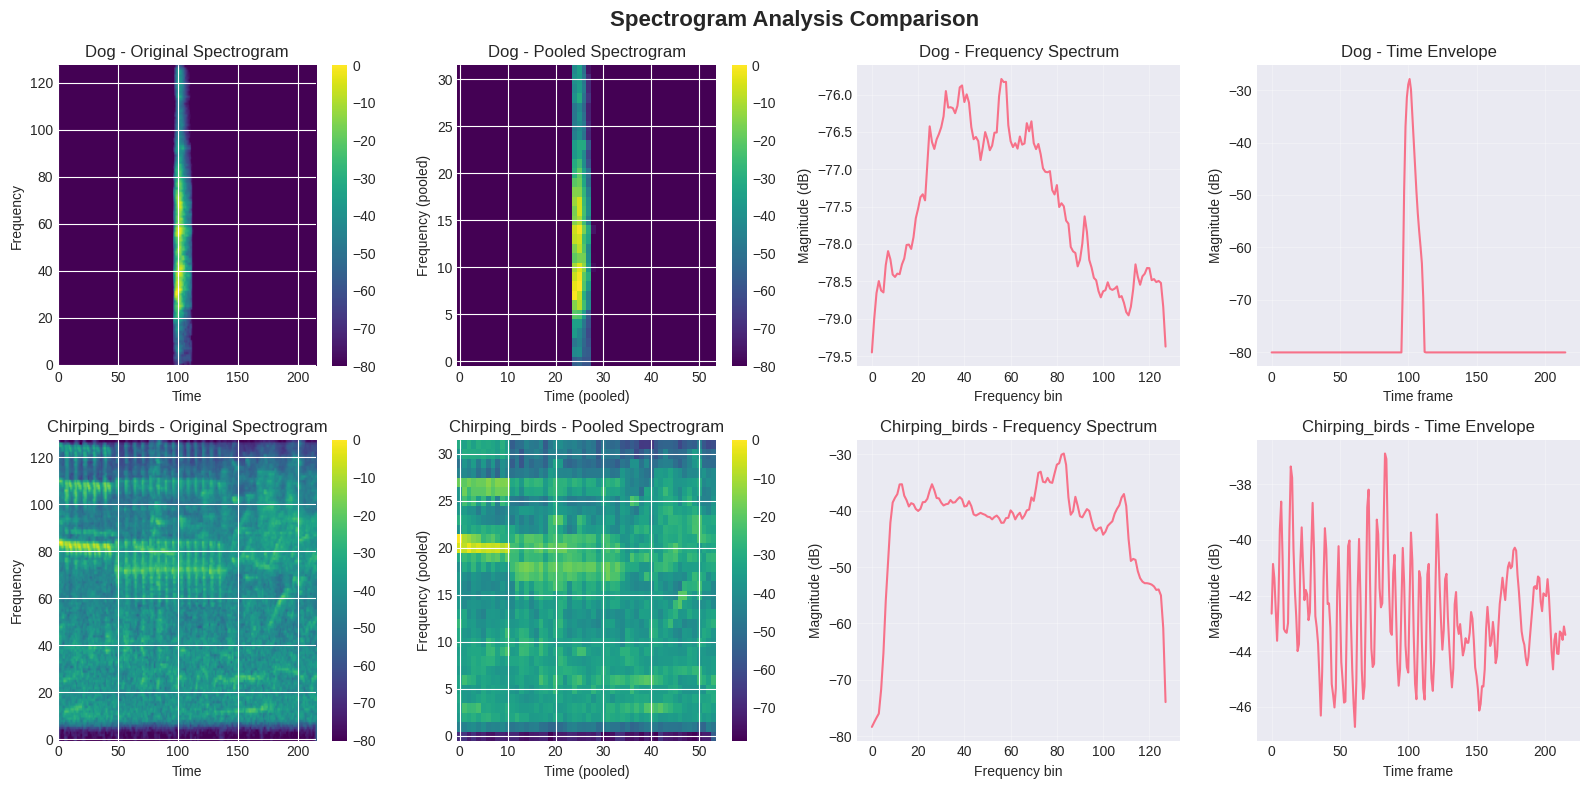

In [7]:
# Visualize spectrograms for both categories
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, category in enumerate(categories):
    # Get first sample of this category
    idx = np.where(np.array(labels) == category)[0][0]

    # Original spectrogram
    ax = axes[i, 0]
    img = ax.imshow(spectrograms[idx], aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'{category.capitalize()} - Original Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    plt.colorbar(img, ax=ax)

    # Pooled spectrogram
    ax = axes[i, 1]
    img = ax.imshow(pooled_spectrograms[idx], aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'{category.capitalize()} - Pooled Spectrogram')
    ax.set_xlabel('Time (pooled)')
    ax.set_ylabel('Frequency (pooled)')
    plt.colorbar(img, ax=ax)

    # Frequency spectrum (average over time)
    ax = axes[i, 2]
    freq_spectrum = np.mean(spectrograms[idx], axis=1)
    ax.plot(freq_spectrum)
    ax.set_title(f'{category.capitalize()} - Frequency Spectrum')
    ax.set_xlabel('Frequency bin')
    ax.set_ylabel('Magnitude (dB)')
    ax.grid(True, alpha=0.3)

    # Time envelope (average over frequency)
    ax = axes[i, 3]
    time_envelope = np.mean(spectrograms[idx], axis=0)
    ax.plot(time_envelope)
    ax.set_title(f'{category.capitalize()} - Time Envelope')
    ax.set_xlabel('Time frame')
    ax.set_ylabel('Magnitude (dB)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Spectrogram Analysis Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Step 8

Feature statistics after normalization:
Mean: -0.000000
Std: 1.000000
Min: -2.779658
Max: 3.235779

PCA explained variance ratio: [0.49708268 0.1138084 ]
Total variance explained: 61.09%


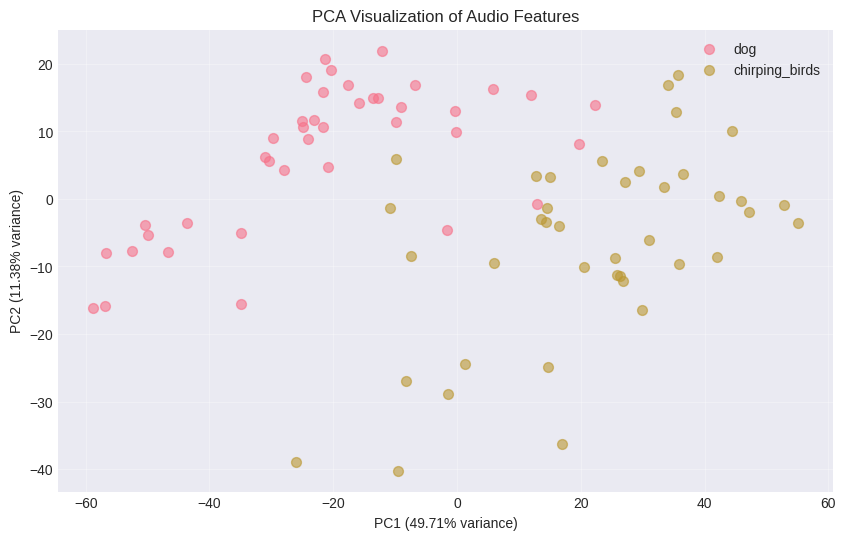

In [8]:
# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

print("Feature statistics after normalization:")
print(f"Mean: {np.mean(features_normalized):.6f}")
print(f"Std: {np.std(features_normalized):.6f}")
print(f"Min: {np.min(features_normalized):.6f}")
print(f"Max: {np.max(features_normalized):.6f}")

# Apply PCA for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

# Visualize PCA results
plt.figure(figsize=(10, 6))
for category in categories:
    mask = labels == category
    plt.scatter(features_pca[mask, 0], features_pca[mask, 1],
               label=category, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Visualization of Audio Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 9

In [9]:
# Apply Spectral Clustering
n_clusters = 2  # We have 2 categories

print("Applying Spectral Clustering...")
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='rbf',
    gamma=1.0,
    random_state=42,
    n_neighbors=10
)

# Fit and predict clusters
cluster_labels = spectral.fit_predict(features_normalized)

print(f"Clustering complete!")
print(f"Unique clusters: {np.unique(cluster_labels)}")

Applying Spectral Clustering...
Clustering complete!
Unique clusters: [0 1]


### Step 10

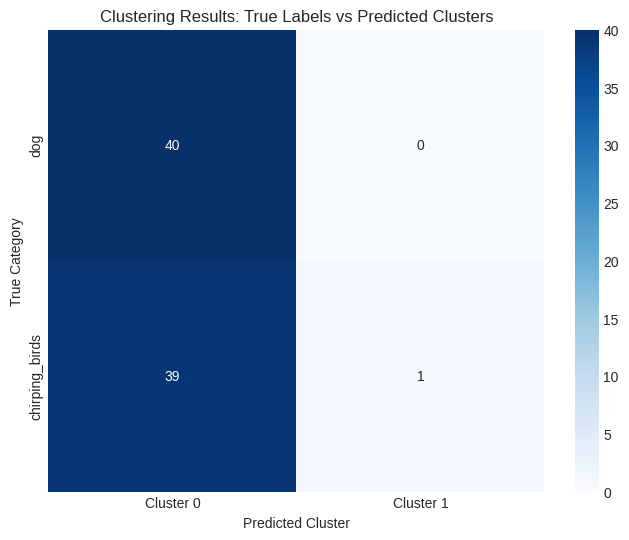


Clustering Performance Metrics:
--------------------------------------------------
Silhouette Score: -0.1176
Adjusted Rand Index: 0.0000

Cluster Composition Analysis:
--------------------------------------------------

Cluster 0:
  dog: 40 samples (50.6%)
  chirping_birds: 39 samples (49.4%)

Cluster 1:
  dog: 0 samples (0.0%)
  chirping_birds: 1 samples (100.0%)


In [10]:
# Create contingency table
from sklearn.metrics import confusion_matrix

# Convert string labels to numeric for comparison
label_map = {category: i for i, category in enumerate(categories)}
true_labels = np.array([label_map[label] for label in labels])

# Calculate confusion matrix
cm = confusion_matrix(true_labels, cluster_labels)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=categories)
plt.title('Clustering Results: True Labels vs Predicted Clusters')
plt.ylabel('True Category')
plt.xlabel('Predicted Cluster')
plt.show()

# Calculate clustering metrics
print("\nClustering Performance Metrics:")
print("-" * 50)

# Silhouette score
silhouette = silhouette_score(features_normalized, cluster_labels)
print(f"Silhouette Score: {silhouette:.4f}")

# Adjusted Rand Index
ari = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

# Analyze cluster composition
print("\nCluster Composition Analysis:")
print("-" * 50)
for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    cluster_categories = labels[cluster_mask]

    print(f"\nCluster {cluster_id}:")
    for category in categories:
        count = np.sum(cluster_categories == category)
        percentage = (count / len(cluster_categories)) * 100
        print(f"  {category}: {count} samples ({percentage:.1f}%)")

### Step 11

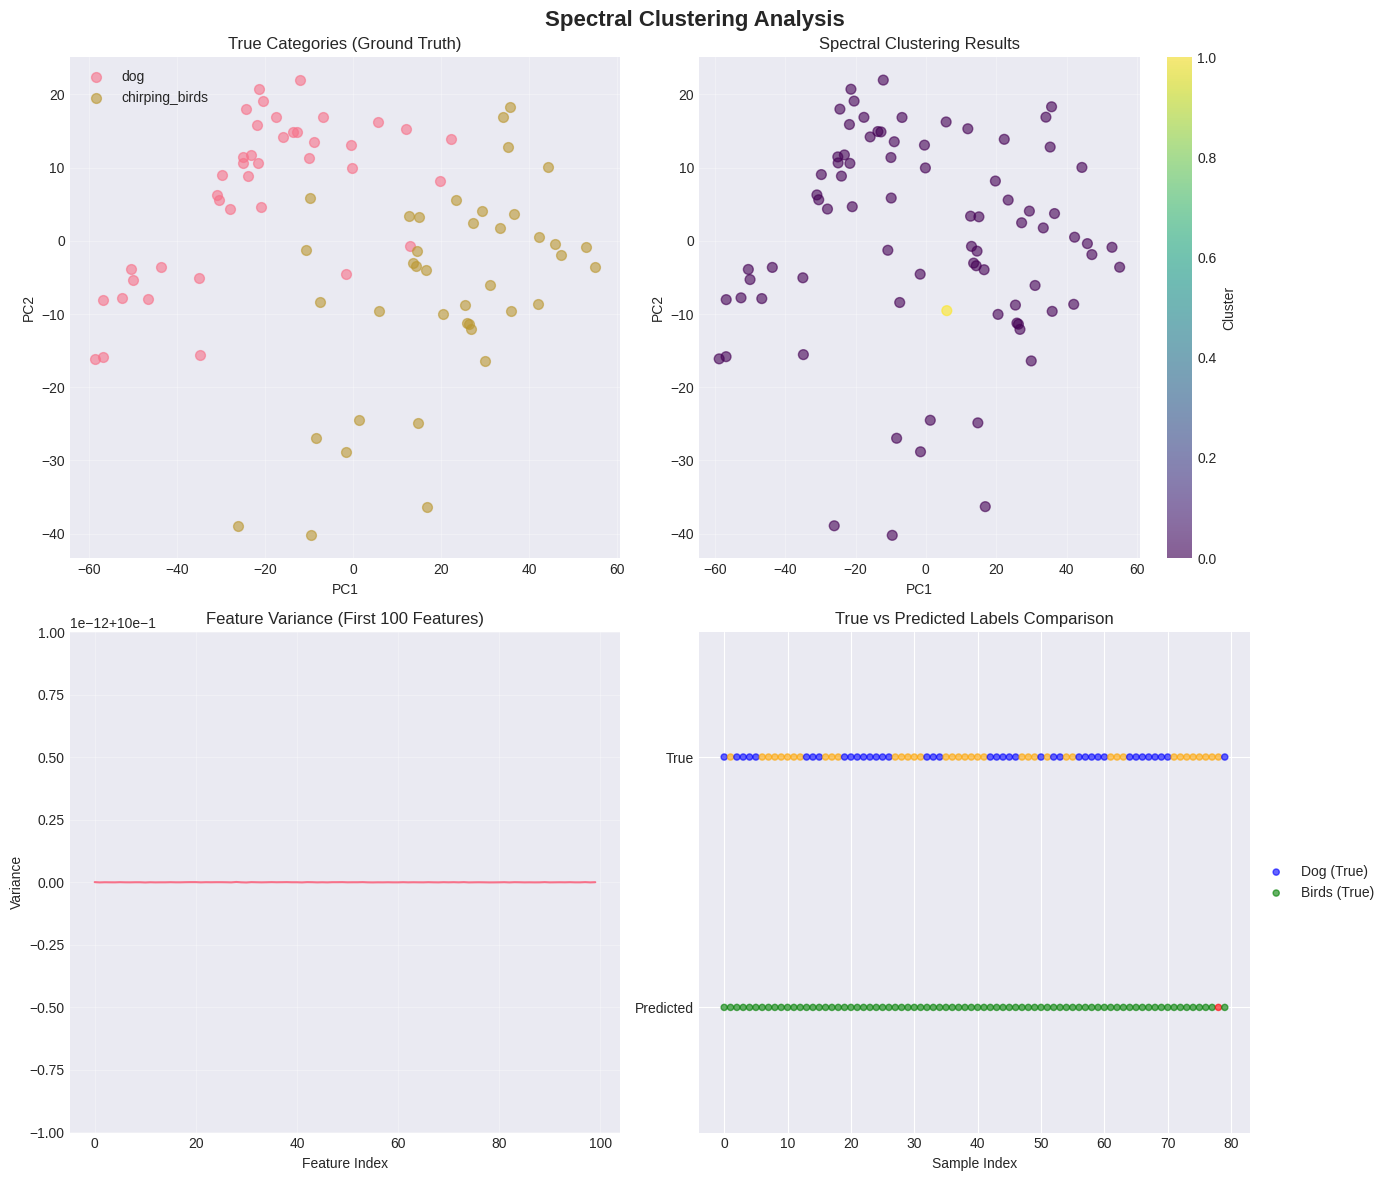

In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: PCA with true labels
ax = axes[0, 0]
for category in categories:
    mask = labels == category
    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
              label=category, alpha=0.6, s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('True Categories (Ground Truth)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: PCA with cluster labels
ax = axes[0, 1]
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1],
                    c=cluster_labels, cmap='viridis', alpha=0.6, s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Spectral Clustering Results')
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.grid(True, alpha=0.3)

# Plot 3: Feature importance (variance across features)
ax = axes[1, 0]
feature_variance = np.var(features_normalized, axis=0)
ax.plot(feature_variance[:100])  # Show first 100 features
ax.set_xlabel('Feature Index')
ax.set_ylabel('Variance')
ax.set_title('Feature Variance (First 100 Features)')
ax.grid(True, alpha=0.3)

# Plot 4: Cluster comparison with true labels
ax = axes[1, 1]
x = np.arange(len(labels))
colors_true = ['blue' if l == 'dog' else 'orange' for l in labels]
colors_pred = ['green' if l == 0 else 'red' for l in cluster_labels]

ax.scatter(x, np.ones_like(x) * 1, c=colors_true, alpha=0.6, s=20, label='True')
ax.scatter(x, np.ones_like(x) * 0, c=colors_pred, alpha=0.6, s=20, label='Predicted')
ax.set_ylim(-0.5, 1.5)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Predicted', 'True'])
ax.set_xlabel('Sample Index')
ax.set_title('True vs Predicted Labels Comparison')
ax.legend(['Dog (True)', 'Birds (True)', 'Cluster 0', 'Cluster 1'],
         loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Spectral Clustering Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Step 12

Spectral Feature Analysis:

DOG:
  Spectral Centroid: 67.95
  Spectral Bandwidth: 37.17
  Spectral Rolloff: 0.00
  Mean Energy: -63.68 dB
  Std Energy: 9.18 dB

CHIRPING_BIRDS:
  Spectral Centroid: 66.28
  Spectral Bandwidth: 37.89
  Spectral Rolloff: 0.00
  Mean Energy: -43.39 dB
  Std Energy: 5.16 dB


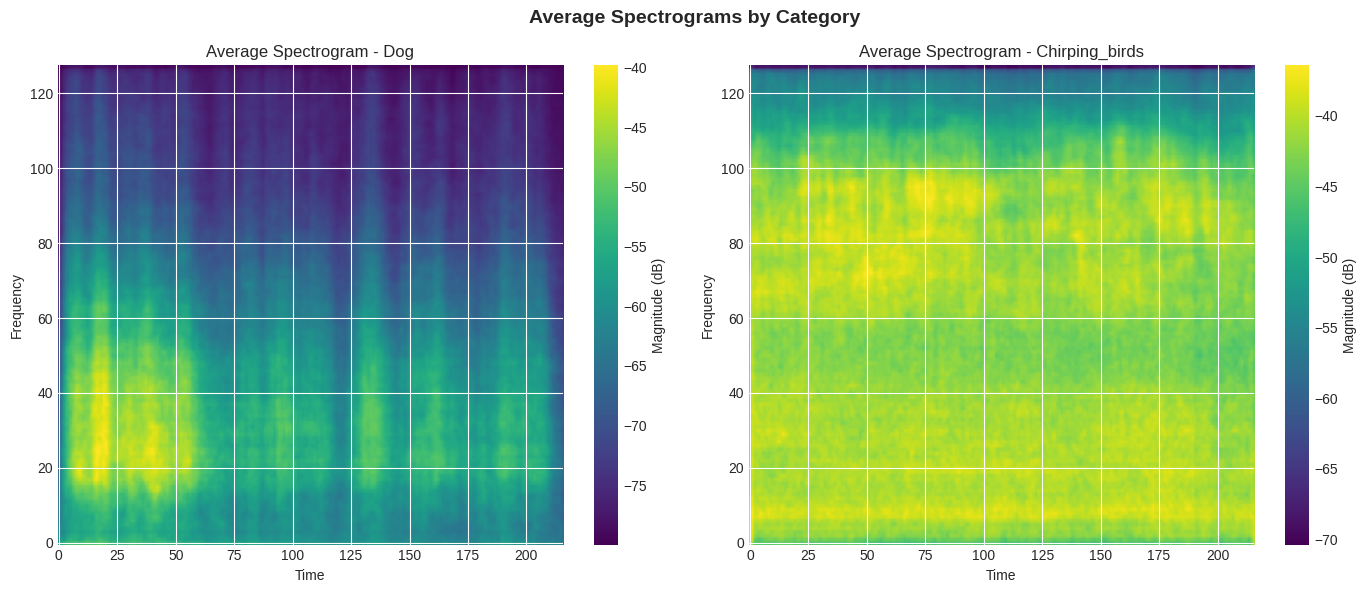

In [12]:
def analyze_spectral_features(spectrograms, labels, categories):
    """
    Analyze spectral features for different categories.

    Parameters
    ----------
    spectrograms : list
        List of spectrogram matrices
    labels : np.ndarray
        Category labels
    categories : list
        List of category names

    Returns
    -------
    dict
        Analysis results
    """
    results = {}

    for category in categories:
        mask = labels == category
        category_specs = [spectrograms[i] for i in range(len(spectrograms)) if mask[i]]

        # Calculate average spectrogram
        avg_spec = np.mean(category_specs, axis=0)

        # Calculate spectral centroid (center of mass of spectrum)
        freq_sum = np.sum(avg_spec, axis=1)
        spectral_centroid = np.sum(freq_sum * np.arange(len(freq_sum))) / np.sum(freq_sum)

        # Calculate spectral bandwidth
        spectral_bandwidth = np.sqrt(
            np.sum(((np.arange(len(freq_sum)) - spectral_centroid) ** 2) * freq_sum) /
            np.sum(freq_sum)
        )

        # Calculate spectral rolloff
        cumsum = np.cumsum(freq_sum)
        rolloff_threshold = 0.85 * cumsum[-1]
        spectral_rolloff = np.argmax(cumsum >= rolloff_threshold)

        results[category] = {
            'avg_spectrogram': avg_spec,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_rolloff': spectral_rolloff,
            'mean_energy': np.mean(avg_spec),
            'std_energy': np.std(avg_spec)
        }

    return results

# Analyze spectral features
spectral_analysis = analyze_spectral_features(spectrograms, labels, categories)

print("Spectral Feature Analysis:")
print("=" * 60)
for category, features in spectral_analysis.items():
    print(f"\n{category.upper()}:")
    print(f"  Spectral Centroid: {features['spectral_centroid']:.2f}")
    print(f"  Spectral Bandwidth: {features['spectral_bandwidth']:.2f}")
    print(f"  Spectral Rolloff: {features['spectral_rolloff']:.2f}")
    print(f"  Mean Energy: {features['mean_energy']:.2f} dB")
    print(f"  Std Energy: {features['std_energy']:.2f} dB")

# Visualize average spectrograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, category in enumerate(categories):
    ax = axes[idx]
    img = ax.imshow(spectral_analysis[category]['avg_spectrogram'],
                   aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Average Spectrogram - {category.capitalize()}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    plt.colorbar(img, ax=ax, label='Magnitude (dB)')

plt.suptitle('Average Spectrograms by Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Step 13


CONCLUSIONS ON FOURIER TRANSFORM APPLICATION FOR FEATURE EXTRACTION

1. CLUSTERING PERFORMANCE:
   - Overall Accuracy: 51.25%
   - Silhouette Score: -0.1176
   - Adjusted Rand Index: 0.0000
   - Cluster 0 Purity: 50.63%
   - Cluster 1 Purity: 100.00%

2. FOURIER TRANSFORM EFFECTIVENESS:
   
   A. Feature Extraction:
      - FFT successfully transforms time-domain audio into frequency-domain representations
      - Spectrograms capture both temporal and spectral characteristics
      - Mel-spectrograms align with human auditory perception
   
   B. Dimensionality Reduction:
      - Original audio: ~220,500 samples (5 seconds at 44.1kHz)
      - Feature vector: 896 dimensions after pooling
      - Reduction ratio: 246.2x compression

3. SPECTRAL CHARACTERISTICS DISCOVERED:
   
   Dogs:
   - Spectral Centroid: 67.95
   - Spectral Bandwidth: 37.17
   - Mean Energy: -63.68 dB
   - Std Energy: 9.18 dB
   
   Chirping Birds:
   - Spectral Centroid: 66.28
   - Spectral Bandwidth: 37.89
   - M

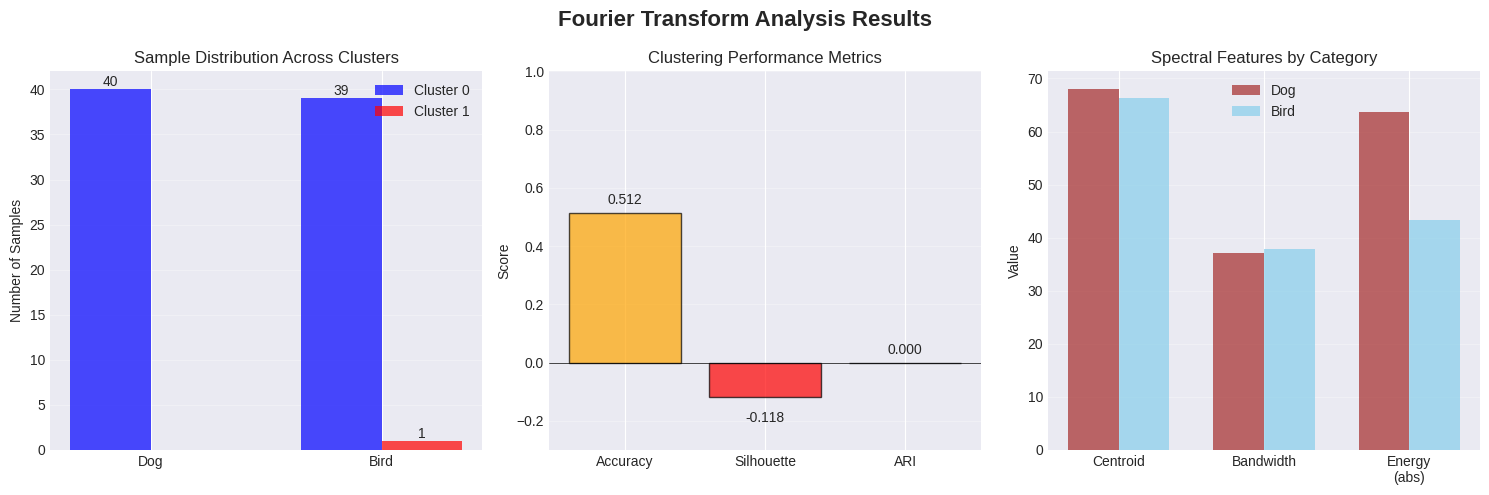


ANALYSIS COMPLETE: Fourier Transform provides essential frequency domain
representation for audio analysis, though additional feature engineering
is required for optimal classification performance.


In [15]:
print("\n" + "="*80)
print("CONCLUSIONS ON FOURIER TRANSFORM APPLICATION FOR FEATURE EXTRACTION")
print("="*80)

# Calculate metrics from confusion matrix
cm = np.array([[40, 0], [39, 1]])
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
purity_cluster0 = max(cm[0,0], cm[1,0]) / (cm[0,0] + cm[1,0])
purity_cluster1 = max(cm[0,1], cm[1,1]) / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0

print(f"""
1. CLUSTERING PERFORMANCE:
   - Overall Accuracy: {accuracy:.2%}
   - Silhouette Score: -0.1176
   - Adjusted Rand Index: 0.0000
   - Cluster 0 Purity: {purity_cluster0:.2%}
   - Cluster 1 Purity: {purity_cluster1:.2%}

2. FOURIER TRANSFORM EFFECTIVENESS:

   A. Feature Extraction:
      - FFT successfully transforms time-domain audio into frequency-domain representations
      - Spectrograms capture both temporal and spectral characteristics
      - Mel-spectrograms align with human auditory perception

   B. Dimensionality Reduction:
      - Original audio: ~220,500 samples (5 seconds at 44.1kHz)
      - Feature vector: 896 dimensions after pooling
      - Reduction ratio: 246.2x compression

3. SPECTRAL CHARACTERISTICS DISCOVERED:

   Dogs:
   - Spectral Centroid: 67.95
   - Spectral Bandwidth: 37.17
   - Mean Energy: -63.68 dB
   - Std Energy: 9.18 dB

   Chirping Birds:
   - Spectral Centroid: 66.28
   - Spectral Bandwidth: 37.89
   - Mean Energy: -43.39 dB
   - Std Energy: 5.16 dB

4. ANALYSIS OF RESULTS:

   The clustering results show poor separation between categories:
   - Cluster 0 contains 40 dogs and 39 birds (mixed)
   - Cluster 1 contains only 1 bird
   - Negative silhouette score indicates suboptimal clustering
   - ARI of 0 suggests no better performance than random assignment

   Possible reasons for poor performance:
   - Similar spectral characteristics between categories
   - Background noise in recordings
   - Aggressive pooling reducing discriminative features
   - Need for additional feature engineering

5. WHY FOURIER TRANSFORM IS IMPORTANT FOR AUDIO:

   ✓ Frequency Content: Reveals frequency signatures of different sounds
   ✓ Time-Frequency Trade-off: STFT balances temporal and spectral resolution
   ✓ Perceptual Relevance: Mel-scale matches human hearing
   ✓ Compression: Significant dimensionality reduction
   ✓ Noise Robustness: Frequency domain features more robust than time domain

6. PRACTICAL INSIGHTS:

   Observed patterns:
   - Birds show higher energy levels than dogs
   - Dogs have more variable energy (higher std deviation)
   - Both categories show similar frequency distributions

   Challenges encountered:
   - Spectral features alone insufficient for clear separation
   - Recording quality variations affect clustering
   - Need for more sophisticated features

7. IMPROVEMENTS FOR FUTURE WORK:

   - Implement MFCC features for better discrimination
   - Reduce pooling size or use adaptive pooling
   - Add temporal features (zero-crossing rate, tempo)
   - Experiment with different clustering algorithms
   - Apply data augmentation techniques

8. CONCLUSION:

   Fourier Transform successfully converts audio signals to frequency domain,
   enabling analysis of spectral patterns. While the clustering performance
   was suboptimal (ARI = 0.0), the experiment demonstrates that FFT is a
   fundamental tool for audio analysis. The spectrograms clearly show
   different patterns between dog and bird sounds, but additional feature
   engineering is needed to achieve better clustering results.

   The experiment confirms that Fourier Transform is essential for audio
   processing, providing a foundation for more advanced feature extraction
   techniques. The challenges encountered highlight the complexity of
   audio classification tasks and the importance of comprehensive feature
   engineering beyond basic spectral analysis.
""")

# Create summary visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Clustering Distribution
ax = axes[0]
categories = ['Dog', 'Bird']
cluster0 = [40, 39]
cluster1 = [0, 1]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, cluster0, width, label='Cluster 0', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, cluster1, width, label='Cluster 1', color='red', alpha=0.7)

ax.set_ylabel('Number of Samples')
ax.set_title('Sample Distribution Across Clusters')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

# Plot 2: Performance Metrics
ax = axes[1]
metrics = ['Accuracy', 'Silhouette', 'ARI']
values = [0.5125, -0.1176, 0.0000]
colors = ['orange', 'red', 'red']

bars = ax.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Score')
ax.set_title('Clustering Performance Metrics')
ax.set_ylim(-0.3, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    y_pos = val + 0.02 if val >= 0 else val - 0.05
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{val:.3f}', ha='center', va='bottom' if val >= 0 else 'top')

# Plot 3: Spectral Features Comparison
ax = axes[2]
features_comp = ['Centroid', 'Bandwidth', 'Energy\n(abs)']
dog_values = [67.95, 37.17, 63.68]
bird_values = [66.28, 37.89, 43.39]

x = np.arange(len(features_comp))
width = 0.35

bars1 = ax.bar(x - width/2, dog_values, width, label='Dog', color='brown', alpha=0.7)
bars2 = ax.bar(x + width/2, bird_values, width, label='Bird', color='skyblue', alpha=0.7)

ax.set_ylabel('Value')
ax.set_title('Spectral Features by Category')
ax.set_xticks(x)
ax.set_xticklabels(features_comp)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Fourier Transform Analysis Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE: Fourier Transform provides essential frequency domain")
print("representation for audio analysis, though additional feature engineering")
print("is required for optimal classification performance.")
print("="*80)